#### Importação das bibliotecas

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer

from scikeras.wrappers import KerasRegressor

from keras.models import Sequential
from keras.layers import Input, LSTM, Dropout, Dense
from keras.callbacks import EarlyStopping


#### Carregamento e ajuste dos dados

In [2]:
data = pd.read_csv('./data/BTC-USD.csv')
data = data.iloc[2:,:]
data.head(10)

,Price,Close,High,Low,Open,Volume
2,2014-09-17,457.3340148925781,468.17401123046875,452.4219970703125,465.864013671875,21056800
3,2014-09-18,424.44000244140625,456.8599853515625,413.10400390625,456.8599853515625,34483200
4,2014-09-19,394.7959899902344,427.8349914550781,384.5320129394531,424.1029968261719,37919700
5,2014-09-20,408.90399169921875,423.2959899902344,389.88299560546875,394.6730041503906,36863600
6,2014-09-21,398.8210144042969,412.4259948730469,393.1809997558594,408.0849914550781,26580100
7,2014-09-22,402.1520080566406,406.9159851074219,397.1300048828125,399.1000061035156,24127600
8,2014-09-23,435.7909851074219,441.5570068359375,396.1969909667969,402.0920104980469,45099500
9,2014-09-24,423.2049865722656,436.11199951171875,421.1319885253906,435.7510070800781,30627700
10,2014-09-25,411.5740051269531,423.5199890136719,409.4679870605469,423.156005859375,26814400
11,2014-09-26,404.42498779296875,414.93798828125,400.0090026855469,411.4289855957031,21460800


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4018 entries, 2 to 4019
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Price   4018 non-null   object
 1   Close   4018 non-null   object
 2   High    4018 non-null   object
 3   Low     4018 non-null   object
 4   Open    4018 non-null   object
 5   Volume  4018 non-null   object
dtypes: object(6)
memory usage: 188.5+ KB


Aqui notamos que estao todas as colunas com o tipo incorreto, vamos ajustar cada uma delas

In [4]:
cols = ['Close', 'High', 'Low', 'Open', 'Volume']
data[cols] = data[cols].apply(pd.to_numeric, errors='coerce')
data.dtypes

Price      object
Close     float64
High      float64
Low       float64
Open      float64
Volume      int64
dtype: object

Apliquei a função pd.to_numeric em cada uma dessas colunas que converte os valores pra número (float ou int)<br>
Se algum valor não puder ser convertido (por exemplo, "ABC", "?", "-"), o parâmetro errors='coerce' manda ele transformar em NaN (valor nulo)

agora so falta colocar a coluna de data, para o tipo data

In [5]:
data = data.rename(columns={'Price': 'Date'})
data['Date'] = pd.to_datetime(data['Date'])
data.dtypes

Date      datetime64[ns]
Close            float64
High             float64
Low              float64
Open             float64
Volume             int64
dtype: object

In [6]:
data = data.set_index('Date')
data = data.sort_index()
data.head(15)


,Close,High,Low,Open,Volume
Date,,,,,
2014-09-17,457.334015,468.174011,452.421997,465.864014,21056800
2014-09-18,424.440002,456.859985,413.104004,456.859985,34483200
2014-09-19,394.795990,427.834991,384.532013,424.102997,37919700
2014-09-20,408.903992,423.295990,389.882996,394.673004,36863600
2014-09-21,398.821014,412.425995,393.181000,408.084991,26580100
2014-09-22,402.152008,406.915985,397.130005,399.100006,24127600
2014-09-23,435.790985,441.557007,396.196991,402.092010,45099500
2014-09-24,423.204987,436.112000,421.131989,435.751007,30627700
2014-09-25,411.574005,423.519989,409.467987,423.156006,26814400


Agora já ajustei o nome da coluna, transformei para data, coloquei a data como indice do meu dataset e ordenei por garantia, porque vi que a ordem era importante para uma LSTM

In [7]:
data.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [8]:
data[data.duplicated() == True]

,Close,High,Low,Open,Volume
Date,,,,,


#### Explorando um pouco os dados

In [9]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,4018.0,2.487618e+04,2.954574e+04,1.781030e+02,2.506395e+03,1.029073e+04,3.932764e+04,1.233441e+05
High,4018.0,2.536239e+04,3.004142e+04,2.117310e+02,2.571953e+03,1.046631e+04,4.023595e+04,1.244571e+05
Low,4018.0,2.431383e+04,2.897382e+04,1.715100e+02,2.387572e+03,1.002435e+04,3.811345e+04,1.189592e+05
Open,4018.0,2.484895e+04,2.951551e+04,1.768970e+02,2.494930e+03,1.028126e+04,3.930022e+04,1.233394e+05
Volume,4018.0,2.058300e+10,2.186031e+10,5.914570e+06,1.083760e+09,1.650599e+10,3.213259e+10,3.509679e+11


In [10]:
data.median().to_frame(name='median')

,median
Close,1.029073e+04
High,1.046631e+04
Low,1.002435e+04
Open,1.028126e+04
Volume,1.650599e+10


In [11]:
data.var().to_frame(name='var')

,var
Close,8.729507e+08
High,9.024867e+08
Low,8.394820e+08
Open,8.711655e+08
Volume,4.778730e+20


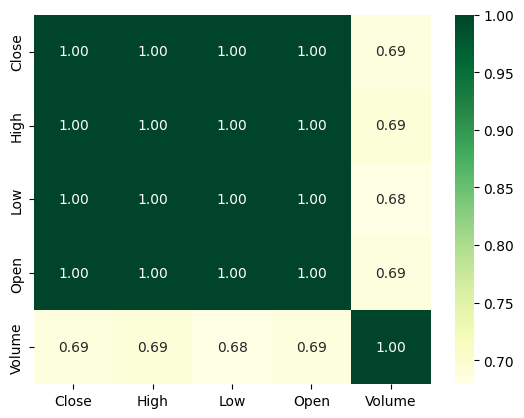

In [12]:
plt.Figure()
sns.heatmap(data.corr(), annot=True, cmap="YlGn", fmt=".2f")
plt.show()

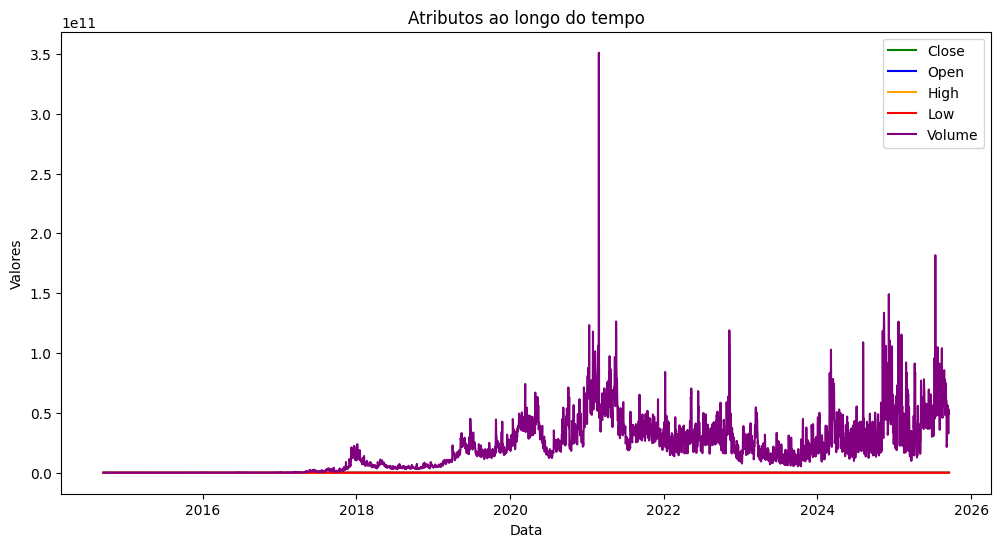

In [13]:
plt.figure(figsize=(12,6))
plt.plot(data.index, data['Close'], label='Close', color='green')
plt.plot(data.index, data['Open'], label='Open', color='blue')
plt.plot(data.index, data['High'], label='High', color='orange')
plt.plot(data.index, data['Low'], label='Low', color='red')
plt.plot(data.index, data['Volume'], label='Volume', color='purple')

plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

Aqui nao conseguimos visualizar bem porque o valor do volume é bem superior aos demais, para melhor visualização vou normalizar os dados

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data)
data_scaled = pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

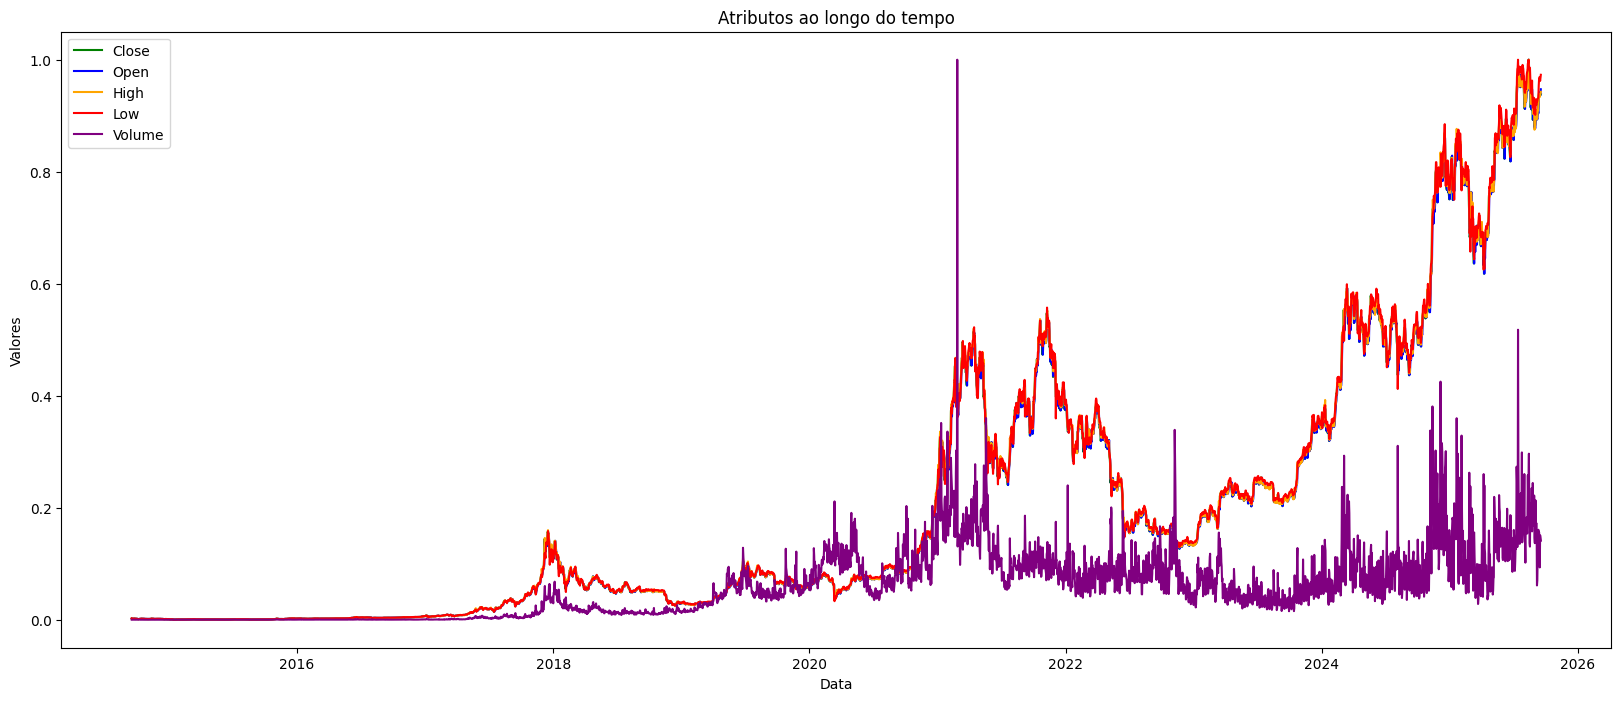

In [15]:
plt.figure(figsize=(20,8))

plt.plot(data_scaled.index, data_scaled['Close'], label='Close', color='green')
plt.plot(data_scaled.index, data_scaled['Open'], label='Open', color='blue')
plt.plot(data_scaled.index, data_scaled['High'], label='High', color='orange')
plt.plot(data_scaled.index, data_scaled['Low'], label='Low', color='red')
plt.plot(data_scaled.index, data_scaled['Volume'], label='Volume', color='purple')

plt.title('Atributos ao longo do tempo')
plt.xlabel('Data')
plt.ylabel('Valores')
plt.legend()
plt.show()

podemos notar que close, open, high e low possuem praticamente a mesma tendencia como acusado pela matriz de correlação, já o volume tem o comportamento diferente, com picos e quedas meio bruscas

#### Aplicação de Modelo para predição

##### OBJETIVOS

- [ ] Comparar com outros métodos

##### Univariado

In [16]:
# def create_sequences(data=[], seq_len=7):
#     X, y = [], []
#     for i in range(len(data) - seq_len):
#         X.append(data[i:i+seq_len])
#         y.append(data[i+seq_len])
#     return np.array(X), np.array(y)


In [17]:
# serie = data['Close']

# train_size = int(0.7 * len(serie))

# train_data = serie[:train_size].values.reshape(-1, 1)
# test_data = serie[train_size:].values.reshape(-1, 1)

# # print(test_data)

# scaler = MinMaxScaler(feature_range=(0,1))
# data_train_scaled = scaler.fit_transform(train_data)
# data_test_scaled = scaler.transform(test_data)


In [18]:
# SEQ_LEN = 14

# X_train_scaled, y_train_scaled = create_sequences(data_train_scaled, SEQ_LEN)
# X_test_scaled, y_test_scaled = create_sequences(data_test_scaled, SEQ_LEN)

In [19]:

# model = Sequential([
#     LSTM(100, input_shape=(SEQ_LEN, 1), return_sequences=True),
#     Dropout(0.2),
#     LSTM(50, return_sequences=False),
#     Dropout(0.2),
#     Dense(1)
# ])

# es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# history = model.fit(
#     X_train_scaled, y_train_scaled,
#     epochs=100,
#     batch_size=32,
#     validation_split=0.1,
#     callbacks=[es],
#     shuffle=False
# )

In [20]:
# plt.figure(figsize=(12,4))
# plt.plot(history.history['loss'], label="Training Loss", color='blue') 
# plt.plot(history.history['val_loss'], label="Validation Loss", color='purple')
# plt.legend()
# plt.show()

In [21]:
# y_pred_scaled = model.predict(X_test_scaled)
# y_pred = scaler.inverse_transform(y_pred_scaled)
# y_test = scaler.inverse_transform(y_test_scaled)

# print(y_test)


##### Multivariado

In [22]:
def create_sequences(X, y, seq_len=14):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])   
        ys.append(y[i+seq_len])    
    return np.array(Xs), np.array(ys)


X = data[['High', 'Low', 'Open', 'Volume']]
y = data[['Close']]

scaler_X = MinMaxScaler(feature_range=(0,1))
scaler_y = MinMaxScaler(feature_range=(0,1))

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y)


In [23]:
def create_lstm_model(seq_len=14, n_features=4, neurons=100, drop=0.2, optimizer='Adam'):
  model = Sequential([
      Input(shape=(seq_len, n_features)),
      LSTM(neurons, return_sequences=True),
      Dropout(drop),
      LSTM((neurons//2), return_sequences=False),
      Dropout(drop),
      Dense(1),
  ])
  model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])
  return model

seq_len_options = [7, 14, 30]
split_options = [3, 5, 10]
models = []

for seq_len in seq_len_options:

  print(f"===== JANELA DE {seq_len} =====")

  X_seq, y_seq = create_sequences(X_scaled, y_scaled, seq_len)

  train_size = int(0.8 * len(X_seq))

  X_train_scaled, X_test_scaled = X_seq[:train_size], X_seq[train_size:]
  y_train_scaled, y_test_scaled = y_seq[:train_size], y_seq[train_size:]

  for split in split_options:
    print(f"_____ SPLIT DE {split} _____")

    model = KerasRegressor(model=create_lstm_model, verbose=0, seq_len=seq_len, n_features=X_train_scaled.shape[2])

    param_grid = {
                    'model__neurons': [16, 32, 64, 128],
                    'model__drop': [0.05, 0.1, 0.2],
                    'batch_size': [16, 32, 64],   
                    'epochs': [50, 100],
                    'model__optimizer': ['Adam'], 
                  }

    tscv = TimeSeriesSplit(n_splits=split)

    grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=tscv, refit=True, scoring="neg_root_mean_squared_error", n_jobs = -1)

    early_stopping = EarlyStopping(monitor='val_mae', patience=10, restore_best_weights=True)

    grid_result = grid.fit(X_train_scaled, y_train_scaled, callbacks=[early_stopping], validation_split=0.2)

    models.append({
      "model": grid_result.best_estimator_,
      "rmse": -grid_result.best_score_,
      "n_splits": split,
      "seq_len": seq_len,
      "params": grid_result.best_params_
    })

    print(f"Menor RMSE: {-grid_result.best_score_:.3f} usando: {grid_result.best_params_}")

===== JANELA DE 7 =====
_____ SPLIT DE 3 _____
Menor RMSE: 0.010 usando: {'batch_size': 64, 'epochs': 100, 'model__drop': 0.05, 'model__neurons': 128, 'model__optimizer': 'Adam'}
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.008 usando: {'batch_size': 32, 'epochs': 100, 'model__drop': 0.1, 'model__neurons': 128, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.008 usando: {'batch_size': 64, 'epochs': 100, 'model__drop': 0.05, 'model__neurons': 128, 'model__optimizer': 'Adam'}
===== JANELA DE 14 =====
_____ SPLIT DE 3 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.011 usando: {'batch_size': 32, 'epochs': 50, 'model__drop': 0.05, 'model__neurons': 128, 'model__optimizer': 'Adam'}
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.008 usando: {'batch_size': 16, 'epochs': 100, 'model__drop': 0.05, 'model__neurons': 128, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.009 usando: {'batch_size': 16, 'epochs': 50, 'model__drop': 0.05, 'model__neurons': 128, 'model__optimizer': 'Adam'}
===== JANELA DE 30 =====
_____ SPLIT DE 3 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.011 usando: {'batch_size': 16, 'epochs': 50, 'model__drop': 0.05, 'model__neurons': 128, 'model__optimizer': 'Adam'}
_____ SPLIT DE 5 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.008 usando: {'batch_size': 16, 'epochs': 50, 'model__drop': 0.05, 'model__neurons': 128, 'model__optimizer': 'Adam'}
_____ SPLIT DE 10 _____


e:\Faculdade\TCC\crypto_predict_tcc\venv\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Menor RMSE: 0.008 usando: {'batch_size': 32, 'epochs': 100, 'model__drop': 0.05, 'model__neurons': 128, 'model__optimizer': 'Adam'}


In [24]:
best_model_entry = min(models, key=lambda x: x["rmse"])
best_model = best_model_entry["model"]
best_model

,model,<function cre...001E02D4D67A0>
,build_fn,None
,warm_start,False
,random_state,None
,optimizer,'rmsprop'
,loss,None
,metrics,None
,batch_size,16
,validation_batch_size,None
,verbose,0
,callbacks,None


In [25]:
y_pred_scaled = grid_result.best_estimator_.predict(X_test_scaled)
y_pred = scaler_y.inverse_transform(y_pred_scaled)
y_test = scaler_y.inverse_transform(y_test_scaled)


In [26]:
# Métricas
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

mae_percent = (mae / len(y_test)) * 100
rmse_percent = (rmse / len(y_test)) * 100
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE(%): {mae_percent:.2f}%")
print(f"RMSE(%): {rmse_percent:.2f}%")
print(f"MAPE(%): {mape:.2f}%")

MAE: 2331.697740444862
RMSE: 3148.7107306415264
MAE(%): 292.19%
RMSE(%): 394.58%
MAPE(%): 3.21%


In [27]:
r2 = r2_score(y_test, y_pred)
print(f"R²: {r2:.2f}")


R²: 0.99


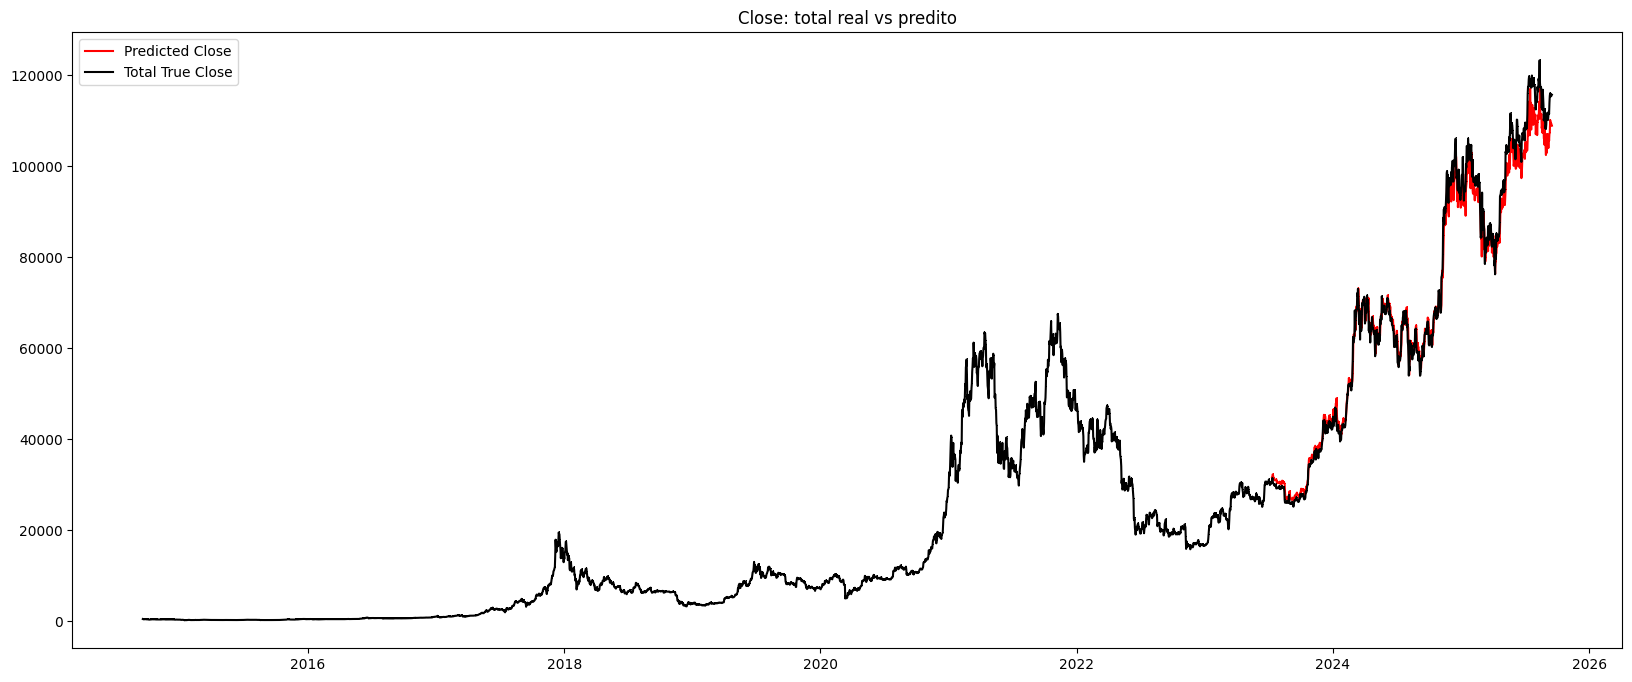

In [28]:
y_pred_plot = np.empty_like(data['Close'])
y_pred_plot[:] = np.nan
y_pred_plot[-len(y_pred):] = y_pred.reshape(-1)

plt.figure(figsize=(20,8))
plt.plot(data.index, y_pred_plot, color="red", marker=",", label='Predicted Close')
plt.plot(data.index, np.array(data['Close']), color="black", marker=",", label='Total True Close')
plt.title('Close: total real vs predito')
plt.legend()
plt.show()

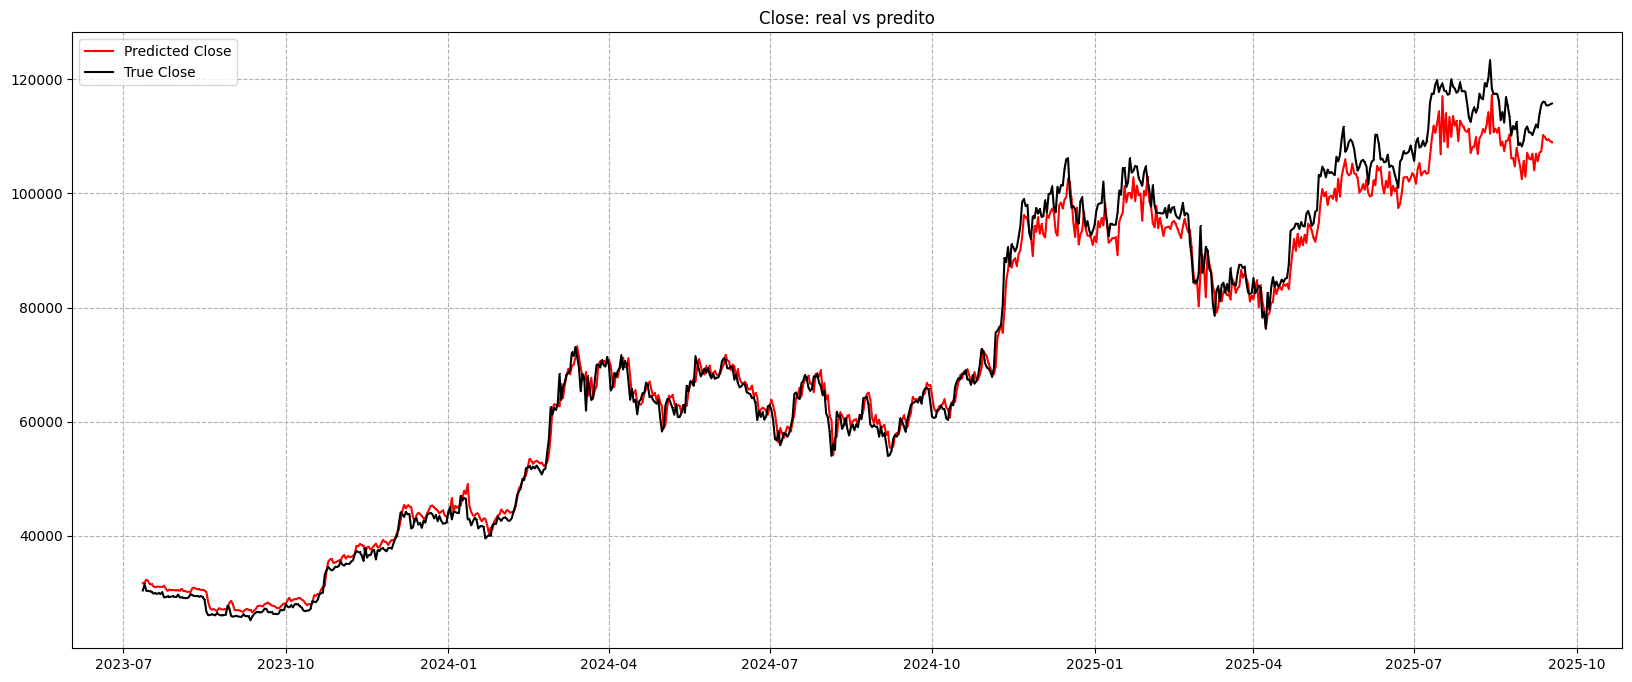

In [29]:
dias_analise=30

plt.figure(figsize=(20,8))
plt.plot(data.index[-len(y_pred):], y_pred, color="red", marker=",", label='Predicted Close')
plt.plot(data.index[-len(y_test):], y_test, color="black", marker=",", label='True Close')
# plt.plot(data.index[-dias_analise:], y_pred[-dias_analise:], color="red", marker=",", label='Predicted Close')
# plt.plot(data.index[-dias_analise:], y_test[-dias_analise:], color="black", marker=",", label='True Close')
plt.title('Close: real vs predito')
plt.legend()
plt.grid(True, linestyle="--")
plt.show()